In [2]:
import sys
sys.path.append("..")

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from matplotlib import cm
from tqdm import tqdm
import time
from tslearn import metrics
from tslearn.metrics import dtw, dtw_path
from scipy.spatial.distance import cdist
from numba import njit, prange, cuda
import numba

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
import stumpy  # local load
import stumpy.core as core

## Load dataset
https://archive.ics.uci.edu/ml/machine-learning-databases/00302/

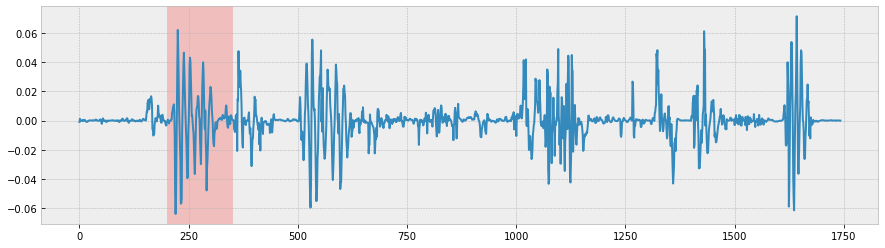

In [3]:
dfx = pd.read_csv("a1_va3.pkl")
v = dfx.values[:, 1]
plt.figure(figsize=(15, 4))
plt.plot(v)
plt.axvspan(200, 350, color="r", alpha=0.2)
plt.show()

# DTW DISTANCE CUDA

In [10]:
T_A = v.astype(np.float64)
T_B = T_A[200:200+150]
n_A = T_A.shape[0]
m = T_B.shape[0]
r = 8
l = n_A - m + 1

(T_A, μ_Q, σ_Q) = stumpy.core.preprocess(T_A, m)
b_m = np.mean(T_B)
b_std = np.std(T_B)
T_Bz = (T_B - b_m)/b_std

excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))
dtw_mask = metrics.sakoe_chiba_mask(m, m, radius=r)
a_start = np.arange(l)
cum_sum = np.full([m+1, m+1], np.inf)
P = np.full(l, np.Inf, dtype=np.float64)
device_cum_sum = cuda.to_device(cum_sum)

@cuda.jit(
    "(f8[:], f8[:], f8[:], f8[:], i8[:],"
    "i8[:, :], f8[:, :], f8[:])"
)
def dtwDistance(T_A, 
                T_Bz, 
                μ_Q, 
                σ_Q, 
                a_start,
                dtw_mask,  # 2
                cum_sum,
                P_):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    n_A = T_A.shape[0]
    
    # idx T_A
    for i_a in range(start, n_A, stride):
        i_a_ = a_start[i_a]
        a_win = T_A[i_a_:i_a_+m]
        cum_sum[0, 0] = 0.

        for i in range(m):
            # normalized T_A
            a = (a_win[i] - μ_Q[i])/σ_Q[i]

            for j in range(m):
                if dtw_mask[i, j] == 0.0:
                    diff_ = (a - T_Bz[j])
                    cum_sum[i + 1, j + 1] = diff_*diff_
                    cum_sum[i + 1, j + 1] += min(cum_sum[i, j + 1],
                                                cum_sum[i + 1, j],
                                                cum_sum[i, j])
        
        P[i_a] = cum_sum[-1, -1]


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(readonly array(float64, 1d, C), int64, float64)
 
There are 16 candidate implementations:
[1m    - Of which 14 did not match due to:
    Overload of function 'setitem': File: <numerous>: Line N/A.
      With argument(s): '(readonly array(float64, 1d, C), int64, float64)':[0m
[1m     No match.[0m
[1m    - Of which 2 did not match due to:
    Overload in function 'SetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 176.
      With argument(s): '(readonly array(float64, 1d, C), int64, float64)':[0m
[1m     Rejected as the implementation raised a specific error:
       NumbaTypeError: [1mCannot modify readonly array of type: readonly array(float64, 1d, C)[0m[0m
  raised from c:\Users\pito\anaconda3\lib\site-packages\numba\core\typing\arraydecl.py:183
[0m
[0m[1mDuring: typing of setitem at C:\Users\pito\AppData\Local\Temp\ipykernel_14264\3309002329.py (54)[0m
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_14264\3309002329.py", line 54:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i_a in range(start, la, stride):
        i_a_ = a_start[i_a]
        a = (T_A[i_a_:i_a_+m] - μ_Q[i_a_])/σ_Q[i_a_]
        
        for i_b in b_start:
            if ignore_trivial == True:
                if np.abs(i_b - i_a_) > excl_zone:
                    b = (T_B[i_b:i_b+m] - M_T[i_b])/Σ_T[i_b]
                    dist = _dtw(a, b, dtw_mask)
                    if dist < ρ[thread_idx, uint64_ia]:
                        ρ[thread_idx, uint64_ia] = dist
                        I[thread_idx, uint64_ia] = uint64_ib

# DTW MP CUDA

In [9]:
T_A = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius
device_id = 0
T_B = None
ignore_trivial=True

if T_B is None:
    T_B = T_A
    ignore_trivial = True

(T_A, μ_Q, σ_Q) = stumpy.core.preprocess(T_A, m)

(T_B, M_T, Σ_T) = stumpy.core.preprocess(T_B, m)

n_A = T_A.shape[0]
n_B = T_B.shape[0]
n = T_B.shape[0]
l = n - m + 1
w = T_A.shape[0] - m + 1

n_threads = numba.config.NUMBA_NUM_THREADS

excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))
# indices_pruned = np.arange(500, 600)

# if indices_pruned is None:
#     indices_pruned = np.array([]).astype(np.int64)
# else:
#     indices_pruned = indices_pruned.astype(np.int64)

if ignore_trivial:
    a_start = np.arange(l)
    b_start = np.arange(l)
    ndist_counts = np.full(l, l)
    # if len(indices_pruned) > 0:
    #     mask_pruned = np.full(l, True)
    #     mask_pruned[indices_pruned] = False
    #     a_start = a_start[mask_pruned]
    #     b_start = a_start
    #     ndist_counts = ndist_counts[mask_pruned]
else:
    lb = n_B - m + 1
    a_start = np.arange(l)
    b_start = np.arange(l)
    ndist_counts = np.full(lb, l)
    # if len(indices_pruned) > 0:
    #     mask_pruned = np.full(l, True)
    #     mask_pruned[indices_pruned] = False
    #     a_start = a_start[mask_pruned]
    #     ndist_counts = ndist_counts[mask_pruned]


dtw_mask = metrics.sakoe_chiba_mask(n_A, n_B, radius=r)

T_A_fname = core.array_to_temp_file(T_A)
T_B_fname = core.array_to_temp_file(T_B)
M_T_fname = core.array_to_temp_file(M_T)
Σ_T_fname = core.array_to_temp_file(Σ_T)
μ_Q_fname = core.array_to_temp_file(μ_Q)
σ_Q_fname = core.array_to_temp_file(σ_Q)
dtw_mask_fname = core.array_to_temp_file(dtw_mask)

device_ids = [device_id]

profile = [None] * len(device_ids)
indices = [None] * len(device_ids)

step = 1 + l // len(device_ids)
for idx, start in enumerate(range(0, l, step)):
    stop = min(l, start + step)
    
    threads_per_block = stumpy.config.STUMPY_THREADS_PER_BLOCK
    blocks_per_grid = math.ceil(w / threads_per_block)

    T_A = np.load(T_A_fname, allow_pickle=False)
    T_B = np.load(T_B_fname, allow_pickle=False)
    M_T = np.load(M_T_fname, allow_pickle=False)
    Σ_T = np.load(Σ_T_fname, allow_pickle=False)
    μ_Q = np.load(μ_Q_fname, allow_pickle=False)
    σ_Q = np.load(σ_Q_fname, allow_pickle=False)
    dtw_mask = np.load(dtw_mask_fname, allow_pickle=False)
    
    with cuda.gpus[device_id]:
        device_T_A = cuda.to_device(T_A)
        device_M_T = cuda.to_device(M_T)
        device_Σ_T = cuda.to_device(Σ_T)
        device_dtw_mask = cuda.to_device(dtw_mask)
        if ignore_trivial:
            device_T_B = device_T_A
            device_μ_Q = device_M_T
            device_σ_Q = device_Σ_T
        else:
            device_T_B = cuda.to_device(T_B)
            device_μ_Q = cuda.to_device(μ_Q)
            device_σ_Q = cuda.to_device(σ_Q)

        profile = np.full(w, np.inf, dtype=np.float64)
        indices = np.full(w, -1, dtype=np.int64)

        device_profile = cuda.to_device(profile)
        device_indices = cuda.to_device(indices)
        
        if ignore_trivial:
            a_start = np.arange(l)
            b_start = np.arange(l)
            ndist_counts = np.full(l, l)
        else:
            lb = n_B - m + 1
            a_start = np.arange(l)
            b_start = np.arange(l)
            ndist_counts = np.full(lb, l)

        a_ranges = core._get_array_ranges(ndist_counts, n_threads, False)

In [10]:
a_ranges

array([[   0,   66],
       [  66,  132],
       [ 132,  198],
       [ 198,  264],
       [ 264,  330],
       [ 330,  396],
       [ 396,  462],
       [ 462,  528],
       [ 528,  594],
       [ 594,  660],
       [ 660,  726],
       [ 726,  792],
       [ 792,  858],
       [ 858,  924],
       [ 924,  990],
       [ 990, 1056],
       [1056, 1122],
       [1122, 1188],
       [1188, 1254],
       [1254, 1320],
       [1320, 1386],
       [1386, 1452],
       [1452, 1518],
       [1518, 1584]], dtype=int64)

In [14]:
@cuda.jit(
    "(f8[:], f8[:], i8, f8[:], f8[:], f8[:], f8[:], f8[:, :],"
    "f8[:], f8[:], i8[:, :], b1, i8, f8[:], i8[:])"
)
def _dtw(
    T_A,
    T_B,
    m,
    M_T,
    Σ_T,
    μ_Q,
    σ_Q,
    dtw_mask,  # 1
    a_start,
    b_start,
    a_ranges,
    ignore_trivial,
    excl_zone,
    profile,
    indices,
):
    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    l = n_A - m + 1
    w = T_A.shape[0] - m + 1
    la = a_start.shape[0]
    lb = b_start.shape[0]

    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i_a in range(start, la, stride):
        i_a_ = a_start[i_a]
        a = (T_A[i_a_:i_a_+m] - μ_Q[i_a_])/σ_Q[i_a_]
        
        for i_b in b_start:
            if ignore_trivial == True:
                if np.abs(i_b - i_a_) > excl_zone:
                    b = (T_B[i_b:i_b+m] - M_T[i_b])/Σ_T[i_b]
                    dist = _dtw(a, b, dtw_mask)
                    if dist < ρ[thread_idx, uint64_ia]:
                        ρ[thread_idx, uint64_ia] = dist
                        I[thread_idx, uint64_ia] = uint64_ib

In [ ]:
@njit(
    # "(f8[:], f8[:], f8[:, :])",
    fastmath=True
)
def _dtw(s1, s2, mask):
    l1 = s1.shape[0]
    l2 = s2.shape[0]
    cum_sum = np.full((l1 + 1, l2 + 1), np.inf)
    cum_sum[0, 0] = 0.

    for i in range(l1):
        for j in range(l2):
            if mask[i, j] == 0.0:
                cum_sum[i + 1, j + 1] = np.square(s1[i] - s2[j])
                cum_sum[i + 1, j + 1] += min(cum_sum[i, j + 1],
                                             cum_sum[i + 1, j],
                                             cum_sum[i, j])
    return cum_sum[-1, -1]

----
## DTW MP
- As structure, two different dtw can be supported.
- Add pruned feature to exstract meaningfull area for dtw calculation, and   
it reduces the bottleneck of DTWMP calculation cost. 

In [3]:
@njit(
    # "(f8[:], f8[:], f8[:, :])",
    fastmath=True
)
def _dtw(s1, s2, mask):
    l1 = s1.shape[0]
    l2 = s2.shape[0]
    cum_sum = np.full((l1 + 1, l2 + 1), np.inf)
    cum_sum[0, 0] = 0.

    for i in range(l1):
        for j in range(l2):
            if mask[i, j] == 0.0:
                cum_sum[i + 1, j + 1] = np.square(s1[i] - s2[j])
                cum_sum[i + 1, j + 1] += min(cum_sum[i, j + 1],
                                             cum_sum[i + 1, j],
                                             cum_sum[i, j])
    return cum_sum[-1, -1]

@njit(
    # "(f8[:], f8[:], i8, i8, i8[:], f8[:], f8[:], f8[:], f8[:], f8[:, :], b1)"
    parallel=True,
    fastmath=True,
)
def _dtwMP(
    T_A,
    T_B,
    m,
    r,
    indices_pruned,
    M_T,
    μ_Q,
    Σ_T,
    σ_Q,
    dtw_mask,
    ignore_trivial,
):
    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    l = n_A - m + 1

    n_threads = numba.config.NUMBA_NUM_THREADS

    excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))

    if ignore_trivial:
        a_start = np.arange(l)
        b_start = np.arange(l)
        ndist_counts = np.full(l, l)
        if len(indices_pruned) > 0:
            mask_pruned = np.full(l, True)
            mask_pruned[indices_pruned] = False
            a_start = a_start[mask_pruned]
            b_start = a_start
            ndist_counts = ndist_counts[mask_pruned]
    else:
        lb = n_B - m + 1
        a_start = np.arange(l)
        b_start = np.arange(l)
        ndist_counts = np.full(lb, l)
        if len(indices_pruned) > 0:
            mask_pruned = np.full(l, True)
            mask_pruned[indices_pruned] = False
            a_start = a_start[mask_pruned]
            ndist_counts = ndist_counts[mask_pruned]

    a_ranges = stumpy.core._get_array_ranges(ndist_counts, n_threads, False)

    ρ = np.full((n_threads, l), np.Inf, dtype=np.float64)
    I = np.full((n_threads, l), -1, dtype=np.int64)
        
    uint64_m = np.uint64(m)
    for thread_idx in prange(n_threads):
        for i_a in range(a_ranges[thread_idx, 0], a_ranges[thread_idx, 1]):
            uint64_ia = np.uint64(a_start[i_a])
            a = (T_A[uint64_ia:uint64_ia+uint64_m] - μ_Q[uint64_ia])/σ_Q[uint64_ia]

            for i_b in b_start:
                if ignore_trivial == True:
                    uint64_ib = np.uint64(i_b)
                    if np.abs(i_b - uint64_ia) > excl_zone:
                        b = (T_B[uint64_ib:uint64_ib+uint64_m] - M_T[uint64_ib])/Σ_T[uint64_ib]
                        dist = _dtw(a, b, dtw_mask)
                        if dist < ρ[thread_idx, uint64_ia]:
                            ρ[thread_idx, uint64_ia] = dist
                            I[thread_idx, uint64_ia] = uint64_ib

                else:
                    uint64_ib = np.uint64(i_b)
                    b = (T_B[uint64_ib:uint64_ib+uint64_m] - M_T[uint64_ib])/Σ_T[uint64_ib]
                    dist = _dtw(a, b, dtw_mask)
                    if dist < ρ[thread_idx, uint64_ia]:
                        ρ[thread_idx, uint64_ia] = dist
                        I[thread_idx, uint64_ia] = uint64_ib

    for thread_idx in range(1, n_threads):
        mask = (ρ[thread_idx, :] < ρ[0, :]) & (I[thread_idx, :] != I[0, :])
        ρ[0, :][mask] = ρ[thread_idx, :][mask]
        I[0, :][mask] = I[thread_idx, :][mask]
        
    return np.sqrt(ρ[0, :]), I[0, :]

    
def dtwMP(T_A, m, r=0, T_B=None, indices_pruned=None, ignore_trivial=True):

    if T_B is None:
        T_B = T_A
        ignore_trivial = True

    if indices_pruned is None:
        indices_pruned = np.array([]).astype(np.int64)

    (T_A, μ_Q, σ_Q) = stumpy.core.preprocess(T_A, m)

    (T_B, M_T, Σ_T) = stumpy.core.preprocess(T_B, m)

    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    l = n_A - m + 1

    dtw_mask = metrics.sakoe_chiba_mask(n_A, n_B, radius=r)

    P, I = _dtwMP(
        T_A,
        T_B,
        m,
        r,
        indices_pruned,
        M_T,
        μ_Q,
        Σ_T,
        σ_Q,
        dtw_mask,
        ignore_trivial,
    )
    
    return P, I

In [4]:
v = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius or maxwarp(paper)
out_dtw = dtwMP(v, m, r)

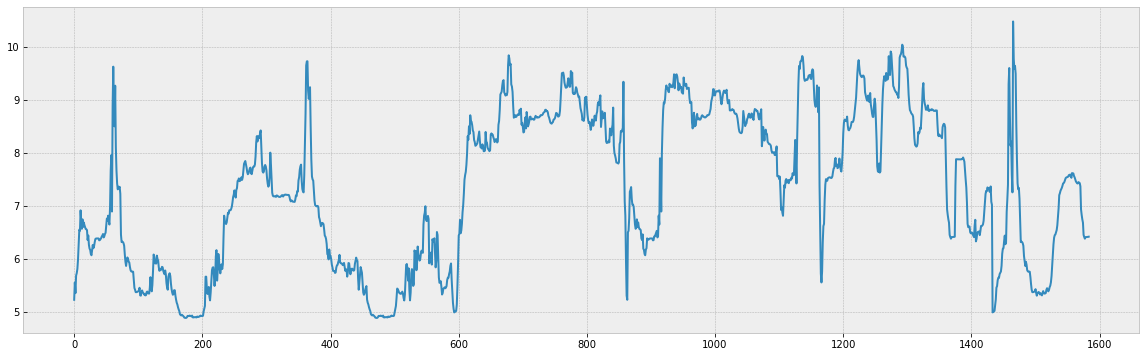

In [5]:
plt.plot(out_dtw[0])

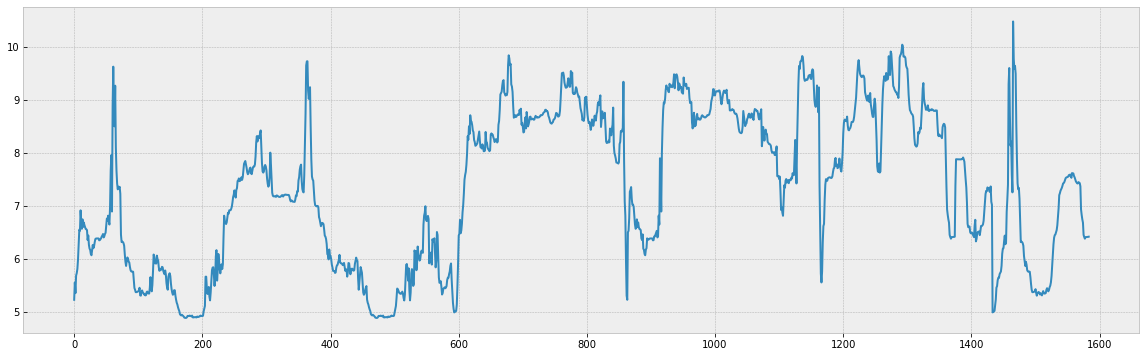

In [6]:
v = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius or maxwarp(paper)
out_dtw = stumpy.dtwMP(v, m, r)
plt.plot(out_dtw[0])